#### To build a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost, follow these steps: First, load and clean your data to ensure it is accurate and relevant. Next, select key features and split the dataset into training and testing sets. Normalize the features through scaling to ensure they are equally weighted. Use a sparse autoencoder to reduce the dimensionality of the data, facilitating more efficient processing. Apply an Isolation Forest to initially identify and isolate potential anomalies. Further refine this detection with XGBoost, enhancing the model's accuracy, especially for subtle anomalies. Finally, evaluate the model using precision, recall, F1-score, and a confusion matrix to assess its overall performance and accuracy. This sequential approach leverages each method's strengths to create a robust and effective anomaly detection system.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

617/617 [==============================] - 0s 697us/step
Precision: 0.912
Recall: 0.912
F1 Score: 0.912
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2365
           1       0.91      0.87      0.89      1582

    accuracy                           0.91      3947
   macro avg       0.91      0.91      0.91      3947
weighted avg       0.91      0.91      0.91      3947



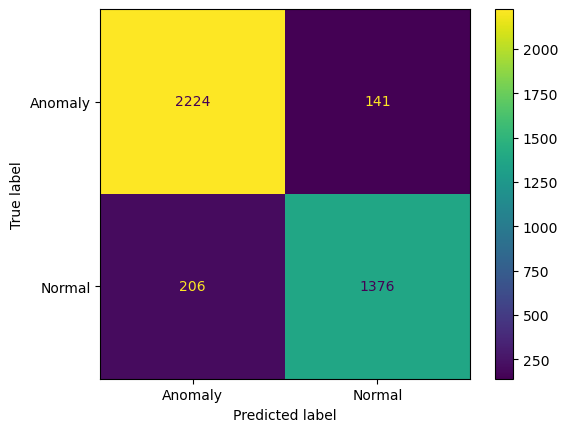

In [9]:

def hybrid_anomaly_detection_MAADM():
    # Load data from a CSV file
    data = pd.read_csv('energydata.csv')
    
    data.dropna(axis=0, inplace=True)
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'Windspeed' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    y = np.where(y_cont > 4, 1, 0)  # Define `threshold` based on the dataset
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    
        
    # Select top k features; you might adjust k based on the dataset
    selector = SelectKBest(score_func=f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    # Dimensionality reduction with sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32  # Dimension of the encoding layer
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True, verbose=0)
    
    encoder = Model(inputs=input_layer, outputs=encoded)
    X_encoded = encoder.predict(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use Isolation Forest to identify normal data points
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_train_scaled)
    
    # Filter only normal data points as identified by Isolation Forest
    normal_indices = np.where(iso_preds == 1)[0]  # Assuming '1' is normal
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train XGBoost on the filtered normal data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_normal, y_train_normal)
    
    # Predict using XGBoost on the test set
    xgb_preds = xgb.predict(X_test_scaled)
    
    # Evaluate the final outcome from XGBoost
    precision = precision_score(y_test, xgb_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, xgb_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, xgb_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    
    print(classification_report(y_test, xgb_preds))


    # Display the confusion matrix
    cm = confusion_matrix(y_test, xgb_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()
    

hybrid_anomaly_detection_MAADM()
